Import

In [726]:
import os
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.offline import iplot
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

torch.set_default_device('cuda')

In [727]:
learning_rate = 0.1
batch_size = 128

creating dataframe

In [728]:
df = pd.read_csv("dataset.csv").iloc[:, :2]
df.columns = ["Date", "Temperature"]
df = df.set_index('Date')
df.index = pd.to_datetime(df.index)
if not df.index.is_monotonic_increasing:
    df = df.sort_index()

print(df)

            Temperature
Date                   
2008-01-11          -20
2008-01-12          -20
2008-01-13           -9
2008-01-14           -6
2008-01-15           -1
...                 ...
2023-11-28            1
2023-11-29           -1
2023-11-30           -4
2023-12-01           -1
2023-12-02           -1

[5778 rows x 1 columns]


Graphics of the temperature change

In [729]:
def df_graph(df: pd.DataFrame, title: str) -> None:
    """ Visualization of graphs

    Args:
        df (pd.DataFrame): current daatframe
        title (str): title
    """
    data = []

    value = go.Scatter(
        x=df.index,
        y=df.Temperature,
        mode="lines",
        name="values",
        marker=dict(),
        text=df.index,
        line=dict(color="rgba(0,0,0, 0.3)"),
    )
    data.append(value)

    layout = dict(
        title=title,
        xaxis=dict(title="Date", ticklen=5, zeroline=False),
        yaxis=dict(title="Temperature", ticklen=5, zeroline=False),
    )

    fig = dict(data=data, layout=layout)
    iplot(fig)


df_graph(df, "Temperature change")

Time lags

In [730]:
def time_lags(df: pd.DataFrame, n_lags: int) -> pd.DataFrame:
    """Generation of observations with a time delay

    Args:
        df (pd.DataFrame): current dataframe
        n_lags (int): count of lags

    Returns:
        pd.DataFrame: dataframe with lags {shift = 1 --> n_lags}
    """
    df_n = df.copy()
    for n in range(1, n_lags + 1):
        df_n[f"lag{n}"] = df_n["Temperature"].shift(n)
    df_n = df_n.iloc[n_lags:]
    return df_n


input_dim = 100

df_timelags = time_lags(df, input_dim)
print(df_timelags)

            Temperature  lag1  lag2  lag3  lag4  lag5  lag6  lag7  lag8  lag9  \
Date                                                                            
2008-04-20           15  12.0  12.0  11.0   8.0   8.0   9.0  20.0  21.0  22.0   
2008-04-21           19  15.0  12.0  12.0  11.0   8.0   8.0   9.0  20.0  21.0   
2008-04-22           18  19.0  15.0  12.0  12.0  11.0   8.0   8.0   9.0  20.0   
2008-04-23            9  18.0  19.0  15.0  12.0  12.0  11.0   8.0   8.0   9.0   
2008-04-24            4   9.0  18.0  19.0  15.0  12.0  12.0  11.0   8.0   8.0   
...                 ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
2023-11-28            1   2.0   2.0   2.0  -6.0 -10.0  -6.0   1.0  -3.0  -5.0   
2023-11-29           -1   1.0   2.0   2.0   2.0  -6.0 -10.0  -6.0   1.0  -3.0   
2023-11-30           -4  -1.0   1.0   2.0   2.0   2.0  -6.0 -10.0  -6.0   1.0   
2023-12-01           -1  -4.0  -1.0   1.0   2.0   2.0   2.0  -6.0 -10.0  -6.0   
2023-12-02           -1  -1.

C:\Users\79379\AppData\Local\Temp\ipykernel_19764\801331584.py:13: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



data splitting

In [731]:
def feature_label_split(df: pd.DataFrame, target_col: str) -> tuple[pd.DataFrame]:
    """Separation of validation and training sets

    Args:
        df (pd.DataFrame): current dataframe
        target_col (str): column in dataframe

    Returns:
        tuple[pd.DataFrame]: origin column and split column
    """
    y = df[[target_col]]
    X = df.drop(columns=[target_col])
    return X, y


def train_val_test_split(df: pd.DataFrame, target_col: str, test_ratio: float) -> tuple[pd.DataFrame]:
    """Separation of validation and training sets

    Args:
        df (pd.DataFrame): current dataframe
        target_col (str): column in dataframe for RNN
        test_ratio (float): num for val_ratio

    Returns:
        tuple[pd.DataFrame]: data for scaling
    """
    val_ratio = test_ratio / (1 - test_ratio)
    X, y = feature_label_split(df, target_col)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_ratio, shuffle=False)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=val_ratio, shuffle=False)
    return X_train, X_val, X_test, y_train, y_val, y_test


X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(
    df_timelags, 'Temperature', 0.2)

Scaling

In [732]:
def get_scaler(scaler: str) -> 'sklearn.preprocessing._data.MinMaxScaler':
    """ selection of scaling type

    Args:
        scaler (str): key for scalers-dict

    Returns:
        sklearn.preprocessing._data.MinMaxScaler: type of scaling method
    """
    scalers = {
        "minmax": MinMaxScaler,
        "standard": StandardScaler,
        "maxabs": MaxAbsScaler,
        "robust": RobustScaler,
    }
    return scalers.get(scaler.lower())()

In [733]:
scaler = get_scaler('minmax')
X_train_arr = scaler.fit_transform(X_train)
X_val_arr = scaler.transform(X_val)
X_test_arr = scaler.transform(X_test)

y_train_arr = scaler.fit_transform(y_train)
y_val_arr = scaler.transform(y_val)
y_test_arr = scaler.transform(y_test)

Data loaders

In [734]:
train_features = torch.Tensor(X_train_arr).cuda()
train_targets = torch.Tensor(y_train_arr).cuda()
val_features = torch.Tensor(X_val_arr).cuda()
val_targets = torch.Tensor(y_val_arr).cuda()
test_features = torch.Tensor(X_test_arr).cuda()
test_targets = torch.Tensor(y_test_arr).cuda()

train = TensorDataset(train_features, train_targets)
val = TensorDataset(val_features, val_targets)
test = TensorDataset(test_features, test_targets)

train_loader = DataLoader(train, batch_size=batch_size,
                          shuffle=False, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size,
                        shuffle=False, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size,
                         shuffle=False, drop_last=True)
test_loader_one = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)

RNN model (origin)

In [735]:
class RNNModel(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, layer_dim: int, output_dim: int, dropout_prob: float) -> None:
        """The __init__ method that initiates an RNN instance.

        Args:
            input_dim (int): The number of nodes in the input layer(входной слой)
            hidden_dim (int): The number of nodes in each layer(скрытый слой)
            layer_dim (int): The number of layers in the network(кол-во слоев нейронки)
            output_dim (int): The number of nodes in the output layer(выходной слой)
            dropout_prob (float): The probability of nodes being dropped out(вер-ть исключить эл-т)

        """
        super(RNNModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # RNN layers
        self.rnn = nn.RNN(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """The forward method takes input tensor x and does forward propagation

        Args:
            x (torch.Tensor): The input tensor of the shape (batch size, sequence length, input_dim)

        Returns:
            torch.Tensor: The output tensor of the shape (batch size, output_dim)

        """
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(
            0), self.hidden_dim).requires_grad_()

        # Forward propagation by passing in the input and hidden state into the model
        out, h0 = self.rnn(x, h0.detach())

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)
        return out

Class shell

In [736]:
class Optimization:
    """Optimization is a helper class that allows training, validation, prediction.

    Optimization is a helper class that takes model, loss function, optimizer function
    learning scheduler (optional), early stopping (optional) as inputs. In return, it
    provides a framework to train and validate the models, and to predict future values
    based on the models.

    Attributes:
        model (RNNModel, LSTMModel, GRUModel): Model class created for the type of RNN
        loss_fn (torch.nn.modules.Loss): Loss function to calculate the losses
        optimizer (torch.optim.Optimizer): Optimizer function to optimize the loss function
        train_losses (list[float]): The loss values from the training
        val_losses (list[float]): The loss values from the validation
        last_epoch (int): The number of epochs that the models is trained
    """

    def __init__(self, model: RNNModel, loss_fn: torch.nn.modules.Loss, optimizer: torch.optim.Optimizer) -> None:
        """
        Args:
            model (RNNModel, LSTMModel, GRUModel): Model class created for the type of RNN
            loss_fn (torch.nn.modules.Loss): Loss function to calculate the losses
            optimizer (torch.optim.Optimizer): Optimizer function to optimize the loss function
        """
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.train_losses = []
        self.val_losses = []

    def train_step(self, x: torch.Tensor, y: torch.Tensor) -> None:
        """The method train_step completes one step of training.

        Given the features (x) and the target values (y) tensors, the method completes
        one step of the training. First, it activates the train mode to enable back prop.
        After generating predicted values (yhat) by doing forward propagation, it calculates
        the losses by using the loss function. Then, it computes the gradients by doing
        back propagation and updates the weights by calling step() function.

        Args:
            x (torch.Tensor): Tensor for features to train one step
            y (torch.Tensor): Tensor for target values to calculate losses

        """
        # Sets model to train mode
        self.model.train()

        # Makes predictions
        yhat = self.model(x)

        # Computes loss
        loss = self.loss_fn(y, yhat)

        # Computes gradients
        loss.backward()

        # Updates parameters and zeroes gradients
        self.optimizer.step()
        self.optimizer.zero_grad()

        # Returns the loss
        return loss.item()

    def train(self, train_loader: torch.utils.data.DataLoader, val_loader: torch.utils.data.DataLoader, batch_size: int = 64, n_epochs: int = 50, n_features: int = 1, learning_rate: int = 1e-3) -> None:
        """The method train performs the model training

        The method takes DataLoaders for training and validation datasets, batch size for
        mini-batch training, number of epochs to train, and number of features as inputs.
        Then, it carries out the training by iteratively calling the method train_step for
        n_epochs times. If early stopping is enabled, then it  checks the stopping condition
        to decide whether the training needs to halt before n_epochs steps. Finally, it saves
        the model in a designated file path.

        Args:
            train_loader (torch.utils.data.DataLoader): DataLoader that stores training data
            val_loader (torch.utils.data.DataLoader): DataLoader that stores validation data
            batch_size (int): Batch size for mini-batch training
            n_epochs (int): Number of epochs, i.e., train steps, to train
            n_features (int): Number of feature columns

        """
        model_path = os.path.join("C:\\", "Users", "79379", "Desktop", "lab_5_cuda",
                                  f"{batch_size}", f"{learning_rate}", f"{batch_size}-{learning_rate}.pth")

        for epoch in range(1, n_epochs + 1):
            batch_losses = []
            for x_batch, y_batch in train_loader:
                x_batch = x_batch.view([batch_size, -1, n_features])
                y_batch = y_batch
                loss = self.train_step(x_batch, y_batch)
                batch_losses.append(loss)
            training_loss = np.mean(batch_losses)
            self.train_losses.append(training_loss)

            with torch.no_grad():
                batch_val_losses = []
                for x_val, y_val in val_loader:
                    x_val = x_val.view([batch_size, -1, n_features])
                    y_val = y_val
                    self.model.eval()
                    yhat = self.model(x_val)
                    val_loss = self.loss_fn(y_val, yhat).item()
                    batch_val_losses.append(val_loss)
                validation_loss = np.mean(batch_val_losses)
                self.val_losses.append(validation_loss)

            if (epoch <= 10) | (epoch % 10 == 0):
                print(
                    f"[{epoch}/{n_epochs}] Training loss: {training_loss:.4f}\t Validation loss: {validation_loss:.4f}"
                )

        torch.save(self.model.state_dict(), model_path)

    def evaluate(self, test_loader: torch.utils.data.DataLoader, batch_size: int = 1, n_features: int = 1) -> list[float]:
        """The method evaluate performs the model evaluation

        The method takes DataLoaders for the test dataset, batch size for mini-batch testing,
        and number of features as inputs. Similar to the model validation, it iteratively
        predicts the target values and calculates losses. Then, it returns two lists that
        hold the predictions and the actual values.

        Note:
            This method assumes that the prediction from the previous step is available at
            the time of the prediction, and only does one-step prediction into the future.

        Args:
            test_loader (torch.utils.data.DataLoader): DataLoader that stores test data
            batch_size (int): Batch size for mini-batch training
            n_features (int): Number of feature columns

        Returns:
            list[float]: The values predicted by the model
            list[float]: The actual values in the test set.

        """
        with torch.no_grad():
            predictions = []
            values = []
            for x_test, y_test in test_loader:
                x_test = x_test.view([batch_size, -1, n_features])
                y_test = y_test
                self.model.eval()
                yhat = self.model(x_test)
                predictions.append(yhat.detach().cpu().numpy())
                values.append(y_test.detach().cpu().numpy())

        return predictions, values

    def plot_losses(self, learning_rate: int) -> None:
        """The method plots the calculated loss values for training and validation
        """
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.title("Losses")
        plt.savefig(
            f"{batch_size}\{learning_rate}\losses-{batch_size}-{learning_rate}.png")
        plt.show()
        plt.close()

Model learning

[1/60] Training loss: 0.6609	 Validation loss: 0.2873
[2/60] Training loss: 0.1536	 Validation loss: 0.0379
[3/60] Training loss: 0.0894	 Validation loss: 0.1071
[4/60] Training loss: 0.1248	 Validation loss: 0.0670
[5/60] Training loss: 0.1317	 Validation loss: 0.0564
[6/60] Training loss: 0.1246	 Validation loss: 0.0789
[7/60] Training loss: 0.1342	 Validation loss: 0.0933
[8/60] Training loss: 0.1402	 Validation loss: 0.1057
[9/60] Training loss: 0.1455	 Validation loss: 0.1158
[10/60] Training loss: 0.1500	 Validation loss: 0.1230
[20/60] Training loss: 0.1635	 Validation loss: 0.1203
[30/60] Training loss: 0.1649	 Validation loss: 0.1171
[40/60] Training loss: 0.1653	 Validation loss: 0.1161
[50/60] Training loss: 0.1654	 Validation loss: 0.1159
[60/60] Training loss: 0.1654	 Validation loss: 0.1157


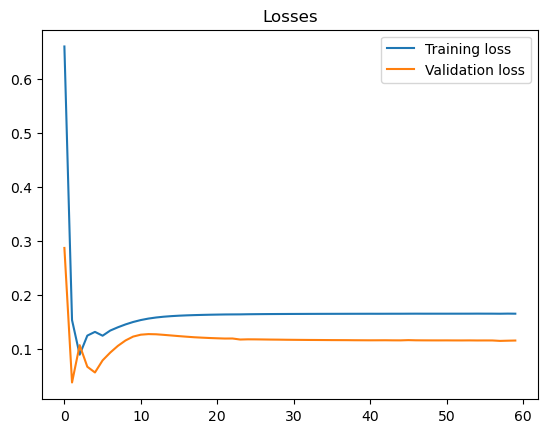

In [737]:
input_dim = len(X_train.columns)
output_dim = 1
hidden_dim = 64
layer_dim = 3
dropout = 0.2
n_epochs = 60
weight_decay = 1e-6

model_params = {'input_dim': input_dim,
                'hidden_dim': hidden_dim,
                'layer_dim': layer_dim,
                'output_dim': output_dim,
                'dropout_prob': dropout}

model = RNNModel(**model_params)

loss_fn = nn.MSELoss(reduction="mean")
optimizer = optim.Adam(
    model.parameters(), lr=learning_rate, weight_decay=weight_decay)


opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
opt.train(train_loader, val_loader, batch_size=batch_size,
          n_epochs=n_epochs, n_features=input_dim, learning_rate=learning_rate)
opt.plot_losses(learning_rate)

predictions, values = opt.evaluate(
    test_loader_one,
    batch_size=1,
    n_features=input_dim
)

forecast format

In [738]:
def inverse_transform(scaler, df: pd.DataFrame, columns: list) -> pd.DataFrame:
    """Get the real values of the forecasts."""
    for col in columns:
        df[col] = scaler.inverse_transform(df[col])
    return df


def format_predictions(predictions: list, values: list, df_test: pd.DataFrame, scaler) -> pd.DataFrame:
    vals = np.concatenate(values, axis=0).ravel()
    preds = np.concatenate(predictions, axis=0).ravel()
    df_result = pd.DataFrame(
        data={"value": vals, "prediction": preds}, index=df_test.head(len(vals)).index)
    df_result = df_result.sort_index()
    df_result = inverse_transform(scaler, df_result, [["value", "prediction"]])
    return df_result


df_result = format_predictions(predictions, values, X_test, scaler)
df_result

,value,prediction
Date,,
2020-10-12,17.999998,-9.972741
2020-10-13,19.000002,-9.972741
2020-10-14,19.000002,-9.972741
2020-10-15,21.000000,-9.972741
2020-10-16,16.000000,-9.972741
...,...,...
2023-11-28,1.000001,-9.972741
2023-11-29,-1.000000,-9.972741
2023-11-30,-3.999999,-9.972741


Mistakes

In [739]:
def calculate_metrics(df: pd.DataFrame) -> dict:
    """Calculate error metrics such as mean absolute error, standard error, and standard error"""
    result_metrics = {'mae': mean_absolute_error(df.value, df.prediction),
                      'rmse': mean_squared_error(df.value, df.prediction) ** 0.5,
                      'r2': r2_score(df.value, df.prediction)}

    print("Mean Absolute Error:       ", result_metrics["mae"])
    print("Root Mean Squared Error:   ", result_metrics["rmse"])
    print("R^2 Score:                 ", result_metrics["r2"])
    return result_metrics


result_metrics = calculate_metrics(df_result)

Mean Absolute Error:        20.36144
Root Mean Squared Error:    24.25890572214537
R^2 Score:                  -1.9303650047688548


Final visualization

In [740]:
def get_temp_by_month(df: pd.DataFrame, start_date: str, end_date: str) -> pd.DataFrame:
    """Getting the temperature in the specified period"""
    df = df.reset_index(inplace=False)
    start_date = pd.to_datetime(start_date, format='%Y-%m-%d')
    end_date = pd.to_datetime(end_date, format='%Y-%m-%d')
    return df[(start_date <= df["Date"]) & (df["Date"] <= end_date)]


get_temp_by_month(df_result, "2023-01-10", "2023-02-10")

,Date,value,prediction
815,2023-01-10,-23.000000,-9.972741
816,2023-01-11,-21.000000,-9.972741
817,2023-01-12,-15.000000,-9.972741
818,2023-01-13,-14.000000,-9.972741
819,2023-01-14,-12.000000,-9.972741
820,2023-01-15,-10.000001,-9.972741
821,2023-01-16,-12.000000,-9.972741
822,2023-01-17,-12.000000,-9.972741
823,2023-01-18,-10.000001,-9.972741
824,2023-01-19,-8.999999,-9.972741


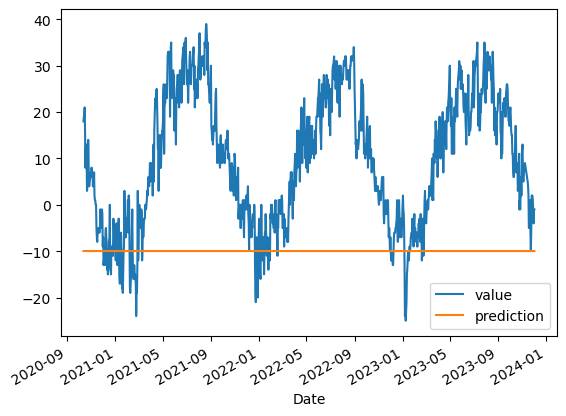

In [741]:
df_result.plot().get_figure().savefig(
    f"{batch_size}\{learning_rate}\\results-{batch_size}-{learning_rate}.png")